# Time series forecasting

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset


In [ ]:
df = pd.read_csv('NN_New_Data.csv')
# slice [start:stop:step], starting from index 5 take every 6th record.

This notebook will deal with **predictions/minute**:

In [ ]:
date_time =  datetime.datetime(2018,1,1) + pd.TimedeltaIndex(df['Time'], unit='m')

In [ ]:
date_time

DatetimeIndex(['2018-01-01 00:01:00', '2018-01-01 00:02:00',
               '2018-01-01 00:03:00', '2018-01-01 00:04:00',
               '2018-01-01 00:05:00', '2018-01-01 00:06:00',
               '2018-01-01 00:07:00', '2018-01-01 00:08:00',
               '2018-01-01 00:09:00', '2018-01-01 00:10:00',
               ...
               '2018-01-07 23:51:00', '2018-01-07 23:52:00',
               '2018-01-07 23:53:00', '2018-01-07 23:54:00',
               '2018-01-07 23:55:00', '2018-01-07 23:56:00',
               '2018-01-07 23:57:00', '2018-01-07 23:58:00',
               '2018-01-07 23:59:00', '2018-01-08 00:00:00'],
              dtype='datetime64[ns]', name='Time', length=10080, freq=None)

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,Time,Ref,HVAC Temp,Building Temp,Total Temp,Buf12,Buf3,Buf4,M1 cons,M2 Consu,M3 cons,M4 cons,Heat cons,Cool cons,Total Consum,Cool On/Off,Heat On/Off,M1,M2,M3,M4
0,1,294.15,0.0,292.148887,292.148887,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,2,294.15,0.0,292.147779,292.147779,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,3,294.15,0.0,292.146677,292.146677,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,4,294.15,0.0,292.145580,292.145580,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,5,294.15,0.0,292.144488,292.144488,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


Here is the evolution of a few features over time. 

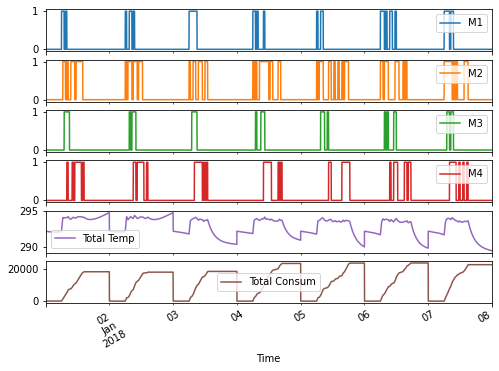

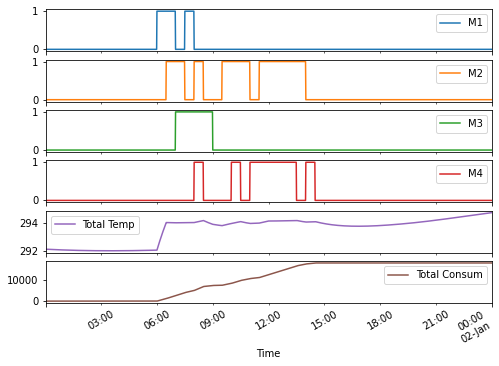

In [ ]:
plot_cols = ['M1', 'M2', 'M3', 'M4','Total Temp','Total Consum']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

View the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,10080.0,5040.500000,2.909990e+03,1.000000e+00,2520.750000,5.040500e+03,7.560250e+03,10080.000000
Ref,10080.0,294.150000,5.434500e-11,2.941500e+02,294.150000,2.941500e+02,2.941500e+02,294.150000
HVAC Temp,10080.0,4.815157,4.326482e+00,0.000000e+00,0.045909,3.491344e+00,7.671874e+00,13.998447
Building Temp,10080.0,287.898097,4.832729e+00,2.758850e+02,284.295045,2.904908e+02,2.917984e+02,292.179120
Total Temp,10080.0,292.713255,1.310243e+00,2.894038e+02,291.917388,2.933950e+02,2.938243e+02,294.760803
Buf12,10080.0,165.525000,1.178984e+02,0.000000e+00,0.450000,2.148000e+02,2.520000e+02,306.000000
Buf3,10080.0,45.935714,3.295237e+01,0.000000e+00,0.000000,7.200000e+01,7.200000e+01,72.000000
Buf4,10080.0,70.228571,6.479475e+01,0.000000e+00,0.000000,6.960000e+01,1.440000e+02,144.000000
M1 cons,10080.0,1530.071429,1.128410e+03,0.000000e+00,12.000000,1.440000e+03,2.880000e+03,3360.000000
M2 Consu,10080.0,5407.366071,4.145409e+03,0.000000e+00,0.000000,6.450000e+03,9.000000e+03,11700.000000


#### Time

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time" signal:

In [ ]:
day = 24*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

Text(0.5, 1.0, 'Time of day signal')

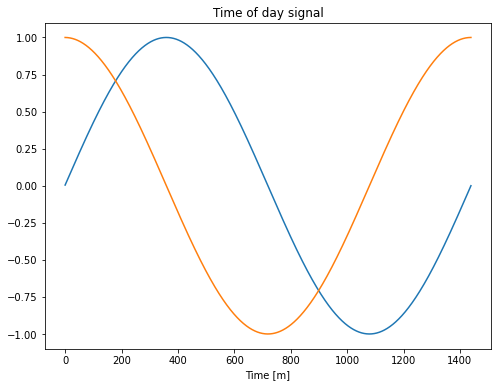

In [ ]:
plt.plot(np.array(df['Day sin'])[:1440])
plt.plot(np.array(df['Day cos'])[:1440])
plt.xlabel('Time [m]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Here Min-Max normalization is used.

In [ ]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. The data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.000000,0.0,0.0,0.998145,0.512434,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.502182,0.999995
1,0.000099,0.0,0.0,0.998077,0.512227,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.504363,0.999981
2,0.000198,0.0,0.0,0.998009,0.512021,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.506545,0.999957
3,0.000298,0.0,0.0,0.997942,0.511817,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.508726,0.999924
4,0.000397,0.0,0.0,0.997875,0.511613,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.510907,0.999881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,0.699573,0.0,1.0,0.051910,0.247432,0.882353,1.0,1.0,0.428571,0.923077,1.0,1.0,1.0,3.826261e-28,0.996766,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.199092,0.899318
7052,0.699673,0.0,1.0,0.051429,0.245967,0.882353,1.0,1.0,0.428571,0.923077,1.0,1.0,1.0,3.826261e-28,0.996766,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.200838,0.900627
7053,0.699772,0.0,1.0,0.050950,0.244510,0.882353,1.0,1.0,0.428571,0.923077,1.0,1.0,1.0,3.826261e-28,0.996766,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.202589,0.901928
7054,0.699871,0.0,1.0,0.050474,0.243063,0.882353,1.0,1.0,0.428571,0.923077,1.0,1.0,1.0,3.826261e-28,0.996766,2.956011e-45,0.0,0.0,0.0,0.0,0.0,0.204345,0.903222


## Data windowing

The models will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

Models development shown here including Linear, DNN, CNN and RNN
First part focuses on implementing the data windowing so that it can be reused for all these models.


## Theory

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

Now we can defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Create two example windows


In [ ]:
w1 = WindowGenerator(input_width=1440, label_width=1440, shift=1440,
                     label_columns=[18])
w1

Total window size: 2880
Input indices: [   0    1    2 ... 1437 1438 1439]
Label indices: [1440 1441 1442 ... 2877 2878 2879]
Label column name(s): [18]

In [ ]:
w2 = WindowGenerator(input_width=300, label_width=1, shift=1,
                     label_columns=[18])
w2

Total window size: 301
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Example try:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[400:400+w2.total_window_size]),
                           np.array(train_df[700:700+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 301, 23)
Inputs shape: (3, 300, 23)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['M1']`. Initially this Notenook will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col=18, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [m]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

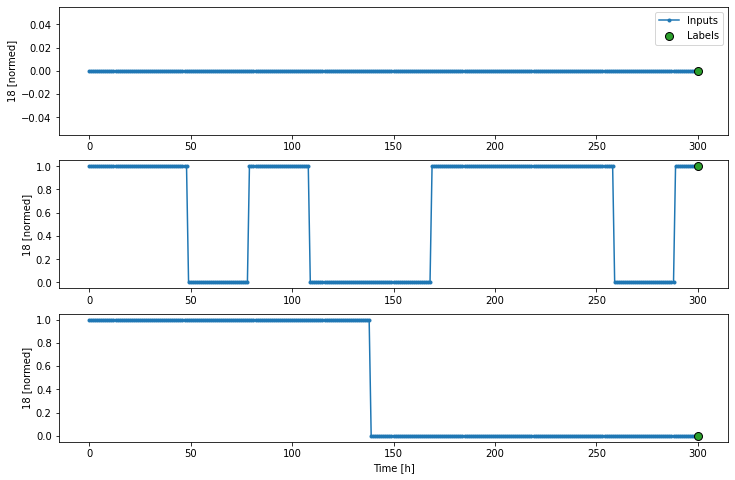

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `M1` column.

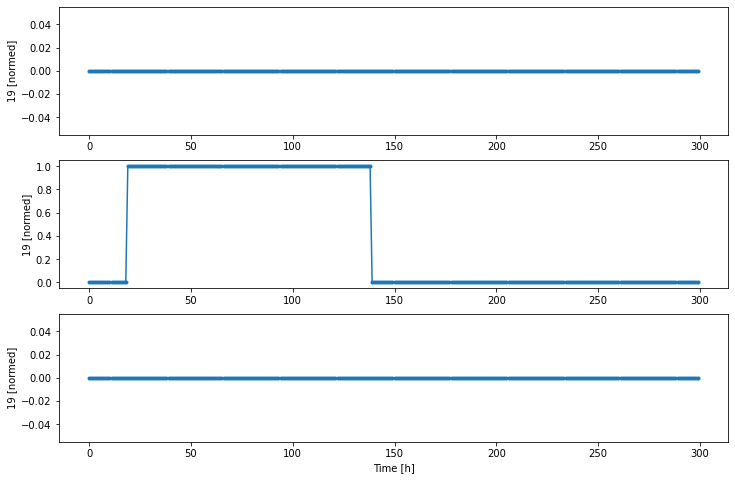

In [ ]:
w2.plot(plot_col=19)

### 4. Create `tf.data.Dataset`s

Use the `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 300, 23), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 300, 23)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1m) in the future based only on the current conditions.

So start by building models to predict the `M1` value 1min into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[18])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): [18]

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 23)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict machine operation 1min in the future given the current value of all features. The current values include the current M1 operation. 

So start with a model that just returns the current state as the prediction, predicting "No change". This is a reasonable baseline since states changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices[18])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0037


That printed some performance metrics, but those don't give any idea about how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [ ]:
wide_window = WindowGenerator(
    input_width=1440, label_width=1440, shift=1,
    label_columns=[18])

wide_window

Total window size: 1441
Input indices: [   0    1    2 ... 1437 1438 1439]
Label indices: [   1    2    3 ... 1438 1439 1440]
Label column name(s): [18]

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 1440, 23)
Output shape: (32, 1440, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

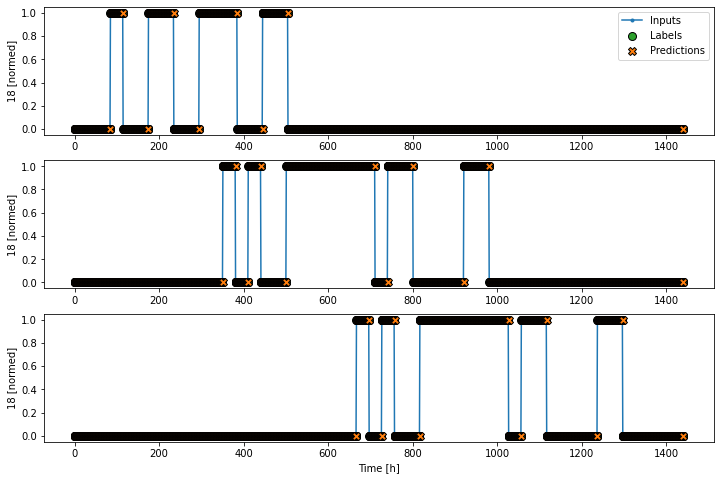

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 23)
Output shape: (32, 1, 1)


This Notebook trains many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 5ms/step - loss: 0.4831 - mean_absolute_error: 0.6119 - val_loss: 0.1216 - val_mean_absolute_error: 0.2461
Epoch 2/20
221/221 [==============================] - 1s 5ms/step - loss: 0.2215 - mean_absolute_error: 0.3643 - val_loss: 0.0777 - val_mean_absolute_error: 0.1805
Epoch 3/20
221/221 [==============================] - 1s 5ms/step - loss: 0.1284 - mean_absolute_error: 0.2576 - val_loss: 0.0627 - val_mean_absolute_error: 0.1795
Epoch 4/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0841 - mean_absolute_error: 0.2001 - val_loss: 0.0524 - val_mean_absolute_error: 0.1742
Epoch 5/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0581 - mean_absolute_error: 0.1649 - val_loss: 0.0422 - val_mean_absolute_error: 0.1571
Epoch 6/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0418 - mean_absolute_error: 0.1376 - val_loss: 0.0325 - val_mean_absolute_error: 0.1334
Epoch 7/20
221/2

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 1440, 23)
Output shape: (32, 1440, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

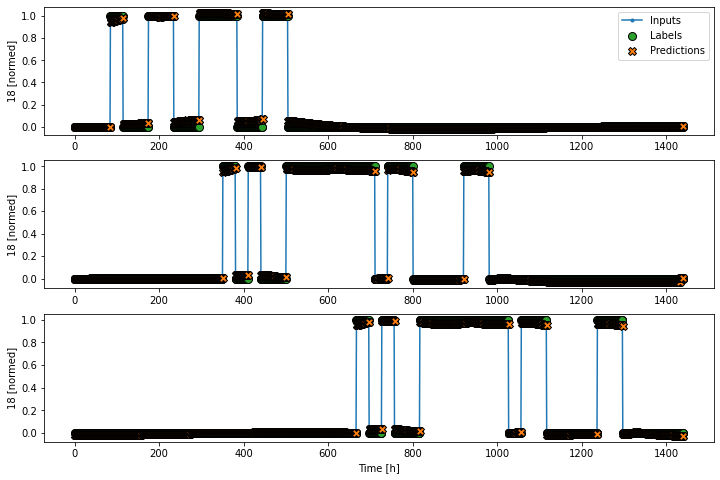

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

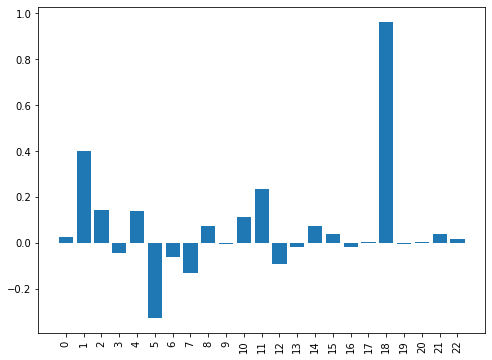

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `M1`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 2s 6ms/step - loss: 0.0704 - mean_absolute_error: 0.1585 - val_loss: 0.0090 - val_mean_absolute_error: 0.0512
Epoch 2/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0080 - mean_absolute_error: 0.0286 - val_loss: 0.0076 - val_mean_absolute_error: 0.0414
Epoch 3/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0264 - val_loss: 0.0086 - val_mean_absolute_error: 0.0500
Epoch 4/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0077 - mean_absolute_error: 0.0285 - val_loss: 0.0064 - val_mean_absolute_error: 0.0318
Epoch 5/20
221/221 [==============================] - 1s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0265 - val_loss: 0.0075 - val_mean_absolute_error: 0.0445
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0465


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[18])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): [18]

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

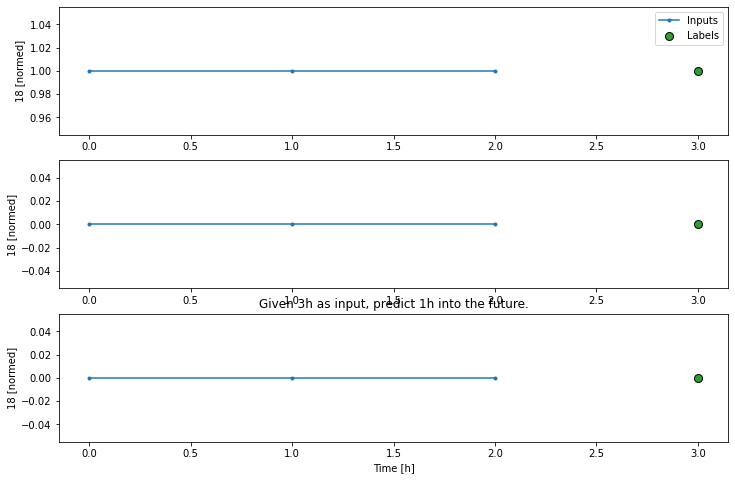

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 23)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0529


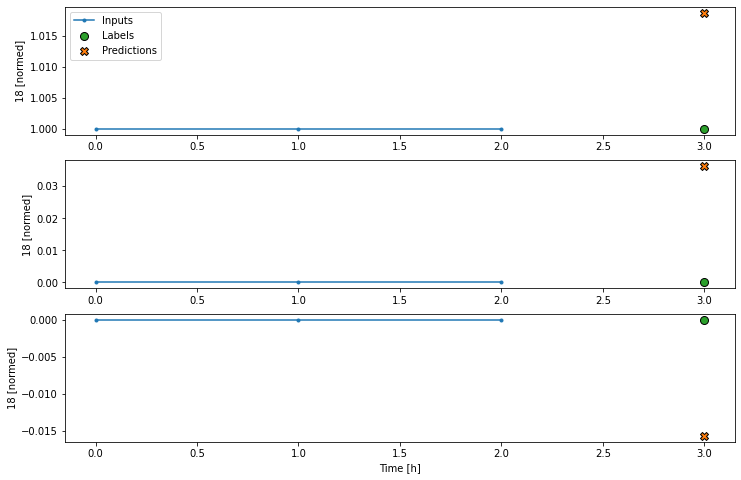

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 1440, 23)

ValueError:Input 0 of layer dense_20 is incompatible with the layer: expected axis -1 of input shape to have value 69 but received input with shape (32, 33120)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 23)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0431


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 1440, 23)
Labels shape: (32, 1440, 1)
Output shape: (32, 1438, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[18])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): [18]

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 23)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

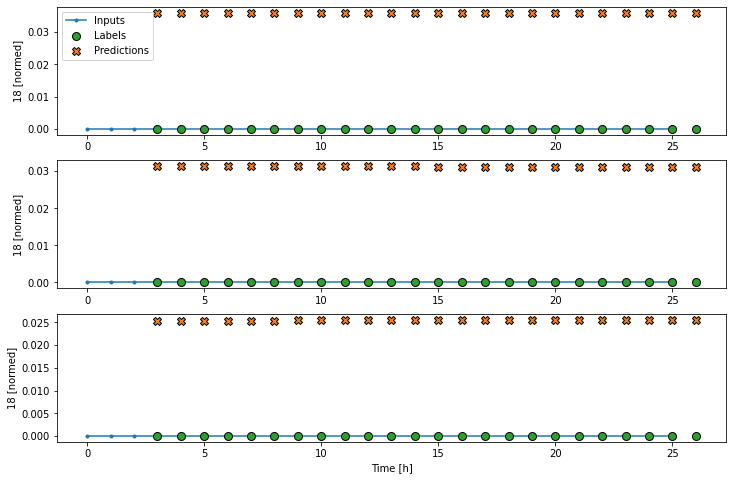

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this Notebook, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 1440, 23)
Output shape: (32, 1440, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

18/18 [==============================] - 0s 21ms/step - loss: 0.0087 - mean_absolute_error: 0.0413


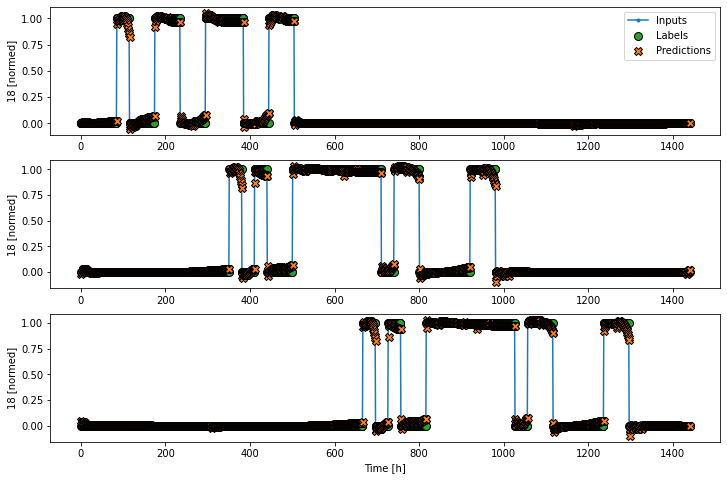

In [ ]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

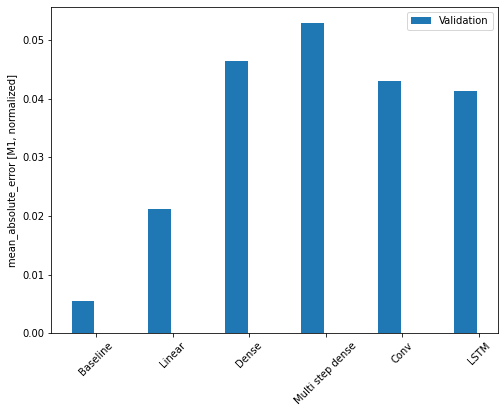

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
#test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [M1, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
#for name, value in performance.items():
#print(f'{name:12s}: {value[1]:0.4f}')

### Multi-output models

The models so far all predicted a single output feature, `M1`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=1440, label_width=1440, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1440, 23)
Labels shape (batch, time, features): (32, 1440, 23)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

18/18 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0019


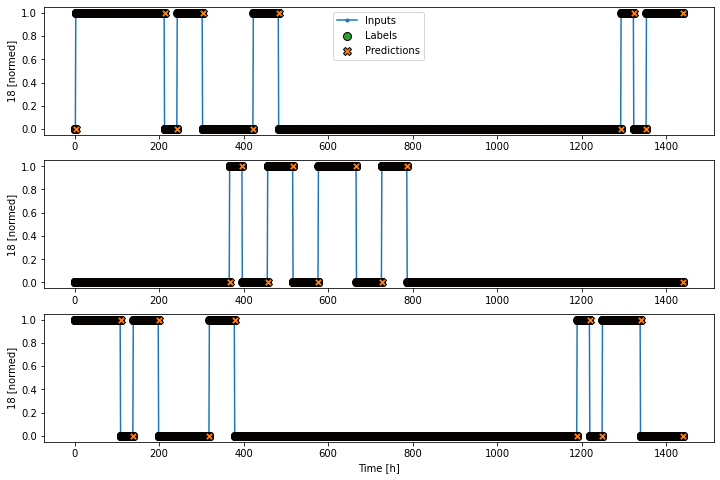

In [ ]:
wide_window.plot(baseline)

#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0314


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=1440, label_width=1440, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

18/18 [==============================] - 0s 23ms/step - loss: 0.0023 - mean_absolute_error: 0.0222

CPU times: user 2min 43s, sys: 16.6 s, total: 2min 59s
Wall time: 2min 47s


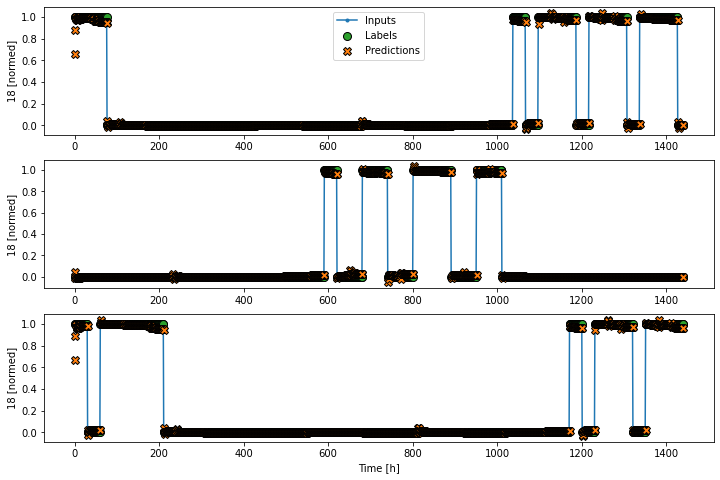

In [ ]:
wide_window.plot(lstm_model)

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this Notebook so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this Notebook. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

18/18 [==============================] - 0s 23ms/step - loss: 0.0016 - mean_absolute_error: 0.0098

CPU times: user 26.2 s, sys: 2.6 s, total: 28.8 s
Wall time: 27 s


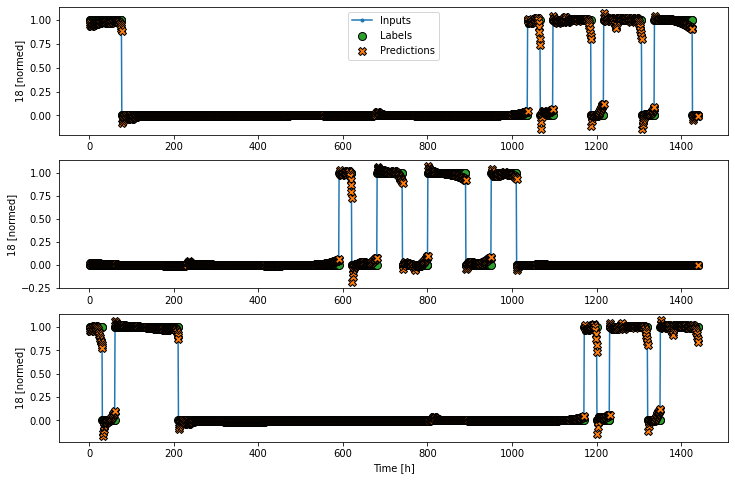

In [ ]:
wide_window.plot(residual_lstm)

#### Performance

Here is the overall performance for these multi-output models.

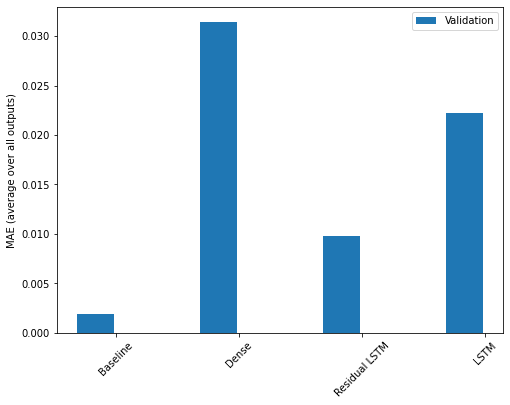

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
#test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()